**Submission Instruction**
1. Save a copy in your drive and replace blank with your name

2. Run all the cells and complete the answer to the question at the end of the notebook

3. Download the .ipynb file and submit on Gradescope



# JSON Flattening and Transforms w/ Spotify Data

This week we're going to be learning how to do transforms with JSON data.  Spotify has a wonderful API that allows access to a ton of their data.  The Spotipy package offers a nice python interface to access that.  

Calls to Spotify yield info on artists/albums/songs all in JSON format.  The goal will be to get artist info along with info on the top 10 songs.  We'll then do some graphical views into the musical preferences of you all!

We'll start by just working through the pipeline with a single artist.  After we learn how to wrangle data of just one artist we'll expand to a big list of artists to make our full dataset.  This takes some looping to make work so figure let's learn to deal with the JSONs first, then the loops.  


## First, installing packages into Colab

The spotipy package isn't preinstalled in Colab, so we gotta do that.  You can do a regular pip install:

`!pip install spotipy`

But the obvious issue here is that this isn't a permanent install, so if you close your notebook and come back later the install will be gone and you'll have to redo it.  Not a huge deal, but also annoying with larger packages.  

What we'll do instead is mount your google drive and install the package to that.  This way whenever you come back your drive will (should) remount and you can load up the package as you normally would.

**Note** You obviously don't have to do this if working locally.

### First - Mount your drive and give access

The code below brings in some utilities and then provides the paths to the notebook and where to install.  The first time you run this in a new notebook you'll have to follow the link, copy the access key and then put into the open cell and hit enter.  After you've done that once the drive should mount automatically when you reopen. *But* I've found that this can be a bit picky so post to Slack if you're having trouble.

In [59]:
import os, sys
from google.colab import drive
drive.mount('/content/mnt')
nb_path = '/content/notebooks'
os.symlink('/content/mnt/My Drive/Colab Notebooks', nb_path)
sys.path.insert(0, nb_path)  # or append(nb_path)

Drive already mounted at /content/mnt; to attempt to forcibly remount, call drive.mount("/content/mnt", force_remount=True).


FileExistsError: [Errno 17] File exists: '/content/mnt/My Drive/Colab Notebooks' -> '/content/notebooks'

In [ ]:
import os, sys
from google.colab import drive
drive.mount('/content/mnt')
nb_path = '/content/notebooks'
sys.path.insert(0, nb_path)  # or append(nb_path)

### Install library

This is a regular install but you're telling it to install that into the notebook path in your drive created above.  

In [ ]:
# Install only once. Tomorrow, you can skip this.
!pip install --target=$nb_path spotipy

## Getting Spotipy up and running

Getting spotipy working is pretty easy!  Here's a step-by-step breakdown.

1.   Go to Spotify Developer Dashboard here: https://developer.spotify.com/dashboard
2.   Sign up to create an account
3.   After sign up click on your name on the top and select Dashboard
4.   Verify your email address and reload the page
5.   Click 'CREATE AN APP' button in upper right
6.   Give it a name and description (the description doesn't matter). For redirect address you can use (https://www.google.com).
Check both Web API and Web Playback SDK
7.   Click create
8.   On the new page it'll show your Client ID and a 'Show Client Secret' line of text
9.   Show the secret.   You'll need that and your ID for the next step.



###  Import spotipy and inputting credentials

In the cell below paste in your unique ID and secret and then run the cell.

We don't alias spotipy, but we do link the credentials to an object called `sp`.  This acts as an alias to spotipy while also providing those.

In [60]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials



spotify_client_id = '8cb6ea88185f4c2b9e60f70b8922e3da'
spotify_client_secret  = 'dcdf5e24c0b249368e152bb8fc868f6e'

client_credentials_manager = SpotifyClientCredentials(
    client_id=spotify_client_id,
    client_secret=spotify_client_secret
)

sp = spotipy.Spotify(
    client_credentials_manager=client_credentials_manager
)

## Working with a single artist

Let's dig in!  We're going to start with just getting info and making things work with just a single artist.  In this case we're going to get the top 10 songs and features by the artist Dance With The Dead.  

You'll see that we actually need to make a range of calls to Spotify in order to build this dataset.  This is because their database is normalized where artist info is in a different database than album info, and those are different from song features...  you get the idea.  

The key thing you need here is the artist URI (the unique identifier).  If you look at the image below you'll see that if you click the `...` you then then scroll to share and then copy the URI. It gives you the following "spotify:artist:2KtnZQwMQJN3uyI8eHZRvm"

![image](https://drive.google.com/uc?export=view&id=1SKmM94qeG0DSWZTaxQ13yQUUu3tGZ-_5)


### Getting artist info

First thing we're going to do is call the `artist()` function on our ID and see what that gets us!

In [61]:
# libraries too :)
import pandas as pd
from pandas import json_normalize

# First, let's get an artist.  Note that you can also copy just the URI.
art = sp.artist('spotify:artist:2KtnZQwMQJN3uyI8eHZRvm')

In [62]:
# Check it out
art

{'external_urls': {'spotify': 'https://open.spotify.com/artist/2KtnZQwMQJN3uyI8eHZRvm'},
 'followers': {'href': None, 'total': 250823},
 'genres': ['synthwave', 'darkwave', 'vaporwave'],
 'href': 'https://api.spotify.com/v1/artists/2KtnZQwMQJN3uyI8eHZRvm',
 'id': '2KtnZQwMQJN3uyI8eHZRvm',
 'images': [{'url': 'https://i.scdn.co/image/ab6761610000e5eb800bdb2c06c690ee4e06a197',
   'height': 640,
   'width': 640},
  {'url': 'https://i.scdn.co/image/ab67616100005174800bdb2c06c690ee4e06a197',
   'height': 320,
   'width': 320},
  {'url': 'https://i.scdn.co/image/ab6761610000f178800bdb2c06c690ee4e06a197',
   'height': 160,
   'width': 160}],
 'name': 'Dance With the Dead',
 'popularity': 50,
 'type': 'artist',
 'uri': 'spotify:artist:2KtnZQwMQJN3uyI8eHZRvm'}

### Just a little JSON

Yep, so our object `art` is a JSON with a bunch of info about the band. A lot of that info is nested as well.  Let's work through it a bit.  

In [63]:
# First, what keys are there?
art.keys()

dict_keys(['external_urls', 'followers', 'genres', 'href', 'id', 'images', 'name', 'popularity', 'type', 'uri'])

In [64]:
# Artist name
print(art['name'])

Dance With the Dead


In [65]:
# Can you get how many total followers there are?  It's two levels deep
print(art['followers']['total'])


250823


In [66]:
# Grab the genre of music
print(art['genres'][0])

synthwave


### Mapping that JSON to a data frame

OK, so you can call up different bits from that JSON using square brackets.  But, the whole point of this is to get the data into a more useful format for analysis, which in this case means a flat structure.

We're going to eventually be working with a long list of artist URIs, so we're going to make a function to extract out those elements to a list.  Then later we can use `map()` to apply that function to each element of the list.  

In [67]:
# To start, you can store just a single element of that above JSON like anything else
artist_name = art['name']
artist_name

'Dance With the Dead'

So let's make a function to extract the name, id, number of followers, and first entry of genre.

If you're rusty, remember that you define a function with the following:
```
def function_name(arguments):
  action
  action
  return(whatever you want to have returned)
```

We're going to make a function called 'get_artist_info'.  This function will take an artist ID and then store the name, id, followers, and genre, and then add them all into a list.  The return will be that list as it'll be easy to turn into a dataframe!


In [68]:
#I'll make this function for you!

def get_artist_info(art_id): # define name and argument
  art_json = sp.artist(art_id) # calling out to the spotipy function using the art_id that was given
  name = art_json['name'] # use that json object to get name
  id = art_json['id'] # artist id
  followers = art_json['followers']['total'] #down a level in followers to get total number
  genre = art['genres'][0] #extracting just the first genre in the list
  art_list = [name, id, followers, genre] # make a list
  return(art_list) # have your function return that list

In [69]:
# Let's call our function on the URI from Dance with the Dead (feel free to try with other artists!)
art_list = get_artist_info('2KtnZQwMQJN3uyI8eHZRvm')
art_list

['Dance With the Dead', '2KtnZQwMQJN3uyI8eHZRvm', 250823, 'synthwave']

In [70]:
# Now we can turn that list into a dataframe using pd.DataFrame()
# You need to provide the list and then a list of column names
# We'll store this as 'artist_info'
artist_info = pd.DataFrame(data = [art_list], columns = ['name', 'id', 'followers', 'genre'])
artist_info

,name,id,followers,genre
0,Dance With the Dead,2KtnZQwMQJN3uyI8eHZRvm,250823,synthwave


## Now to get the top tracks

Now that we have the artist info we can get their top 10 tracks.  The function `artist_top_tracks()` returns just that if you give it an ID

In [71]:
# Assign top 10 songs to artist_top
artist_top = sp.artist_top_tracks(artist_info['id'][0])
artist_top

{'tracks': [{'album': {'album_type': 'album',
    'artists': [{'external_urls': {'spotify': 'https://open.spotify.com/artist/27qG899eLldfpYtPr3S3NJ'},
      'href': 'https://api.spotify.com/v1/artists/27qG899eLldfpYtPr3S3NJ',
      'id': '27qG899eLldfpYtPr3S3NJ',
      'name': 'Scandroid',
      'type': 'artist',
      'uri': 'spotify:artist:27qG899eLldfpYtPr3S3NJ'}],
    'available_markets': ['AR',
     'AU',
     'AT',
     'BE',
     'BO',
     'BR',
     'BG',
     'CA',
     'CL',
     'CO',
     'CR',
     'CY',
     'CZ',
     'DK',
     'DO',
     'DE',
     'EC',
     'EE',
     'SV',
     'FI',
     'FR',
     'GR',
     'GT',
     'HN',
     'HK',
     'HU',
     'IS',
     'IE',
     'IT',
     'LV',
     'LT',
     'LU',
     'MY',
     'MT',
     'MX',
     'NL',
     'NZ',
     'NI',
     'NO',
     'PA',
     'PY',
     'PE',
     'PH',
     'PL',
     'PT',
     'SG',
     'SK',
     'ES',
     'SE',
     'CH',
     'TW',
     'TR',
     'UY',
     'US',
     'GB',
   

In [72]:
# The topmost key is 'tracks' which makes sense as it's 10 indivdiual tracks
artist_top.keys()

dict_keys(['tracks'])

In [73]:
# Let's look at just the second track
artist_top['tracks'][1]

{'album': {'album_type': 'album',
  'artists': [{'external_urls': {'spotify': 'https://open.spotify.com/artist/2KtnZQwMQJN3uyI8eHZRvm'},
    'href': 'https://api.spotify.com/v1/artists/2KtnZQwMQJN3uyI8eHZRvm',
    'id': '2KtnZQwMQJN3uyI8eHZRvm',
    'name': 'Dance With the Dead',
    'type': 'artist',
    'uri': 'spotify:artist:2KtnZQwMQJN3uyI8eHZRvm'}],
  'available_markets': ['AR',
   'AU',
   'AT',
   'BE',
   'BO',
   'BR',
   'BG',
   'CA',
   'CL',
   'CO',
   'CR',
   'CY',
   'CZ',
   'DK',
   'DO',
   'DE',
   'EC',
   'EE',
   'SV',
   'FI',
   'FR',
   'GR',
   'GT',
   'HN',
   'HK',
   'HU',
   'IS',
   'IE',
   'IT',
   'LV',
   'LT',
   'LU',
   'MY',
   'MT',
   'MX',
   'NL',
   'NZ',
   'NI',
   'NO',
   'PA',
   'PY',
   'PE',
   'PH',
   'PL',
   'PT',
   'SG',
   'SK',
   'ES',
   'SE',
   'CH',
   'TW',
   'TR',
   'UY',
   'US',
   'GB',
   'AD',
   'LI',
   'MC',
   'ID',
   'JP',
   'TH',
   'VN',
   'RO',
   'IL',
   'ZA',
   'SA',
   'AE',
   'BH',
   'QA',
 

### Using pandas to normalize our JSONs

So that returned a pretty large json with a lot of information.  We could go and write another function to pull out the information for each track, but instead we're going to use some of the built-in `pandas` JSON parsing functions.  

`json_normalize()` will take that JSON data and turn it into a dataframe.  Let's apply it and see what happens.

In [74]:
# Well this isn't helpful
# The issue is that the data are all down a level under 'tracks'
pd.json_normalize(artist_top)

,tracks
0,"[{'album': {'album_type': 'album', 'artists': ..."


In [75]:
# Let's call it on artist_top['tracks']
# Add .head(3) just to see only the first few.
pd.json_normalize(artist_top['tracks']).head(3)

,artists,available_markets,disc_number,duration_ms,explicit,href,id,is_local,is_playable,name,...,album.images,album.is_playable,album.name,album.release_date,album.release_date_precision,album.total_tracks,album.type,album.uri,external_ids.isrc,external_urls.spotify
0,[{'external_urls': {'spotify': 'https://open.s...,"[AR, AU, AT, BE, BO, BR, BG, CA, CL, CO, CR, C...",1,352105,False,https://api.spotify.com/v1/tracks/249s2jlRWK7e...,249s2jlRWK7eIS1LE3qp5G,False,True,Neo-Tokyo - Dance With The Dead Remix,...,[{'url': 'https://i.scdn.co/image/ab67616d0000...,True,Dreams of Neo-Tokyo,2017-03-31,day,17,album,spotify:album:5jnvDvAuKfrqEEFlclMxrV,QM5LC1700030,https://open.spotify.com/track/249s2jlRWK7eIS1...
1,[{'external_urls': {'spotify': 'https://open.s...,"[AR, AU, AT, BE, BO, BR, BG, CA, CL, CO, CR, C...",1,259834,False,https://api.spotify.com/v1/tracks/68ngtC3pGiTj...,68ngtC3pGiTjXcFwxYCJ7Z,False,True,Diabolic,...,[{'url': 'https://i.scdn.co/image/ab67616d0000...,True,The Shape,2016-02-06,day,10,album,spotify:album:6FrmsWgHEf8JGco0YPFOjJ,TCACL1692678,https://open.spotify.com/track/68ngtC3pGiTjXcF...
2,[{'external_urls': {'spotify': 'https://open.s...,"[AR, AU, AT, BE, BO, BR, BG, CA, CL, CO, CR, C...",1,115728,False,https://api.spotify.com/v1/tracks/1yItTv2O2Ui8...,1yItTv2O2Ui8NmRPt3p7Pq,False,True,March of the Dead,...,[{'url': 'https://i.scdn.co/image/ab67616d0000...,True,Driven to Madness,2022-01-10,day,10,album,spotify:album:3kZ1FQTWCVrz37jwXWBjT5,TCAFY2102387,https://open.spotify.com/track/1yItTv2O2Ui8NmR...


So that worked well overall!  You can see it made columns for all the levels directly under 'tracks'.  

But, there's also information we want that's deeper in the JSON. For example, 'artist' has the artist name and id under it, both of which we'll need to bring our data together.  See below.

In [76]:
artist_top['tracks'][1]['artists']

[{'external_urls': {'spotify': 'https://open.spotify.com/artist/2KtnZQwMQJN3uyI8eHZRvm'},
  'href': 'https://api.spotify.com/v1/artists/2KtnZQwMQJN3uyI8eHZRvm',
  'id': '2KtnZQwMQJN3uyI8eHZRvm',
  'name': 'Dance With the Dead',
  'type': 'artist',
  'uri': 'spotify:artist:2KtnZQwMQJN3uyI8eHZRvm'}]

Luckily `json_normalize()` has more functionality.  You can tell it what path you want it to  normalize with `record_path = ['level you want']`

Let's try it.  Note I tossed in one more argument... `sep = '_'`. `json_normalize()` defaults to using periods as separators, but you should never use those so this'll change it to underscores.

In [ ]:
# Try it!
pd.json_normalize(artist_top['tracks'], record_path=['artists'], sep='_').head(5)

Wait, that got us now our individual data about the artist, but now we lost the data about the songs themselves!

Not to worry, though. You can use the meta = [] to provide a list of other information you want to attach from the json.

Let's get the track id, track name, popularity, and duration. The code would look like this:

In [77]:
pd.json_normalize(artist_top['tracks'],
                  record_path=['artists'],
                  meta = ['id', 'name', 'popularity', 'duration_ms'])



ValueError: Conflicting metadata name id, need distinguishing prefix 

But that throws us an error saying that there's conflicting metadata.

There's an issue here that should hopefully be pretty apparent. Notice above that it also gives us the id contained in the artist section. But we obviously want the song id so we can get that info next. This'll cause a conflict as we'll then have two columns named the same. We can fix this by adding in two other arguments that tell it what prefix to give both the metadata and the record data. Given our record is asking for artist info, let's give that a prefix of 'artist_' and our meta is asking for track info we'll give that 'track_'.

In [78]:
pd.json_normalize(artist_top['tracks'],
  record_path=['artists'],
  meta = ['id', 'name', 'popularity', 'duration_ms'],
  record_prefix = 'artist_',
  meta_prefix = 'track_',
  sep = '_')


,artist_href,artist_id,artist_name,artist_type,artist_uri,artist_external_urls_spotify,track_id,track_name,track_popularity,track_duration_ms
0,https://api.spotify.com/v1/artists/27qG899eLld...,27qG899eLldfpYtPr3S3NJ,Scandroid,artist,spotify:artist:27qG899eLldfpYtPr3S3NJ,https://open.spotify.com/artist/27qG899eLldfpY...,249s2jlRWK7eIS1LE3qp5G,Neo-Tokyo - Dance With The Dead Remix,46,352105
1,https://api.spotify.com/v1/artists/2KtnZQwMQJN...,2KtnZQwMQJN3uyI8eHZRvm,Dance With the Dead,artist,spotify:artist:2KtnZQwMQJN3uyI8eHZRvm,https://open.spotify.com/artist/2KtnZQwMQJN3uy...,249s2jlRWK7eIS1LE3qp5G,Neo-Tokyo - Dance With The Dead Remix,46,352105
2,https://api.spotify.com/v1/artists/2KtnZQwMQJN...,2KtnZQwMQJN3uyI8eHZRvm,Dance With the Dead,artist,spotify:artist:2KtnZQwMQJN3uyI8eHZRvm,https://open.spotify.com/artist/2KtnZQwMQJN3uy...,68ngtC3pGiTjXcFwxYCJ7Z,Diabolic,43,259834
3,https://api.spotify.com/v1/artists/2KtnZQwMQJN...,2KtnZQwMQJN3uyI8eHZRvm,Dance With the Dead,artist,spotify:artist:2KtnZQwMQJN3uyI8eHZRvm,https://open.spotify.com/artist/2KtnZQwMQJN3uy...,1yItTv2O2Ui8NmRPt3p7Pq,March of the Dead,41,115728
4,https://api.spotify.com/v1/artists/0hxQtmgWiPt...,0hxQtmgWiPtEsDPeIuKxXq,John Carpenter,artist,spotify:artist:0hxQtmgWiPtEsDPeIuKxXq,https://open.spotify.com/artist/0hxQtmgWiPtEsD...,1yItTv2O2Ui8NmRPt3p7Pq,March of the Dead,41,115728
5,https://api.spotify.com/v1/artists/5rJxl4BLLAa...,5rJxl4BLLAaFRSNgAz2hSg,Cody Carpenter,artist,spotify:artist:5rJxl4BLLAaFRSNgAz2hSg,https://open.spotify.com/artist/5rJxl4BLLAaFRS...,1yItTv2O2Ui8NmRPt3p7Pq,March of the Dead,41,115728
6,https://api.spotify.com/v1/artists/2KtnZQwMQJN...,2KtnZQwMQJN3uyI8eHZRvm,Dance With the Dead,artist,spotify:artist:2KtnZQwMQJN3uyI8eHZRvm,https://open.spotify.com/artist/2KtnZQwMQJN3uy...,4YPrCV5t9OykPyoI1xSxnR,Hex,41,221419
7,https://api.spotify.com/v1/artists/2KtnZQwMQJN...,2KtnZQwMQJN3uyI8eHZRvm,Dance With the Dead,artist,spotify:artist:2KtnZQwMQJN3uyI8eHZRvm,https://open.spotify.com/artist/2KtnZQwMQJN3uy...,5k3VFeS8Icp6OCc7qsW2ls,Riot,41,227076
8,https://api.spotify.com/v1/artists/2KtnZQwMQJN...,2KtnZQwMQJN3uyI8eHZRvm,Dance With the Dead,artist,spotify:artist:2KtnZQwMQJN3uyI8eHZRvm,https://open.spotify.com/artist/2KtnZQwMQJN3uy...,6lUyyCRoT2wvtGlQQEpk3U,That House,40,286153
9,https://api.spotify.com/v1/artists/2KtnZQwMQJN...,2KtnZQwMQJN3uyI8eHZRvm,Dance With the Dead,artist,spotify:artist:2KtnZQwMQJN3uyI8eHZRvm,https://open.spotify.com/artist/2KtnZQwMQJN3uy...,69F2Y4CInUq7fgIsagg87r,Invader,40,274285


In [79]:
# Lets store our data this time as top_track_info
top_track_info = pd.json_normalize(artist_top['tracks'],
                  record_path=['artists'],
                  meta = ['id', 'name','popularity', 'duration_ms'],
                  record_prefix = 'artist_',
                  meta_prefix = 'track_',
                  sep = '_')

top_track_info.head()

,artist_href,artist_id,artist_name,artist_type,artist_uri,artist_external_urls_spotify,track_id,track_name,track_popularity,track_duration_ms
0,https://api.spotify.com/v1/artists/27qG899eLld...,27qG899eLldfpYtPr3S3NJ,Scandroid,artist,spotify:artist:27qG899eLldfpYtPr3S3NJ,https://open.spotify.com/artist/27qG899eLldfpY...,249s2jlRWK7eIS1LE3qp5G,Neo-Tokyo - Dance With The Dead Remix,46,352105
1,https://api.spotify.com/v1/artists/2KtnZQwMQJN...,2KtnZQwMQJN3uyI8eHZRvm,Dance With the Dead,artist,spotify:artist:2KtnZQwMQJN3uyI8eHZRvm,https://open.spotify.com/artist/2KtnZQwMQJN3uy...,249s2jlRWK7eIS1LE3qp5G,Neo-Tokyo - Dance With The Dead Remix,46,352105
2,https://api.spotify.com/v1/artists/2KtnZQwMQJN...,2KtnZQwMQJN3uyI8eHZRvm,Dance With the Dead,artist,spotify:artist:2KtnZQwMQJN3uyI8eHZRvm,https://open.spotify.com/artist/2KtnZQwMQJN3uy...,68ngtC3pGiTjXcFwxYCJ7Z,Diabolic,43,259834
3,https://api.spotify.com/v1/artists/2KtnZQwMQJN...,2KtnZQwMQJN3uyI8eHZRvm,Dance With the Dead,artist,spotify:artist:2KtnZQwMQJN3uyI8eHZRvm,https://open.spotify.com/artist/2KtnZQwMQJN3uy...,1yItTv2O2Ui8NmRPt3p7Pq,March of the Dead,41,115728
4,https://api.spotify.com/v1/artists/0hxQtmgWiPt...,0hxQtmgWiPtEsDPeIuKxXq,John Carpenter,artist,spotify:artist:0hxQtmgWiPtEsDPeIuKxXq,https://open.spotify.com/artist/0hxQtmgWiPtEsD...,1yItTv2O2Ui8NmRPt3p7Pq,March of the Dead,41,115728


In [80]:
# Let's keep just the columns we need.
# We're going to call for song specifics using track ID, but we'll also want artist ID and name for later.
top_track_info = top_track_info[['artist_name', 'artist_id', 'track_id', 'track_name', 'track_popularity', 'track_duration_ms']]
top_track_info.head()

,artist_name,artist_id,track_id,track_name,track_popularity,track_duration_ms
0,Scandroid,27qG899eLldfpYtPr3S3NJ,249s2jlRWK7eIS1LE3qp5G,Neo-Tokyo - Dance With The Dead Remix,46,352105
1,Dance With the Dead,2KtnZQwMQJN3uyI8eHZRvm,249s2jlRWK7eIS1LE3qp5G,Neo-Tokyo - Dance With The Dead Remix,46,352105
2,Dance With the Dead,2KtnZQwMQJN3uyI8eHZRvm,68ngtC3pGiTjXcFwxYCJ7Z,Diabolic,43,259834
3,Dance With the Dead,2KtnZQwMQJN3uyI8eHZRvm,1yItTv2O2Ui8NmRPt3p7Pq,March of the Dead,41,115728
4,John Carpenter,0hxQtmgWiPtEsDPeIuKxXq,1yItTv2O2Ui8NmRPt3p7Pq,March of the Dead,41,115728


OK great!  We've managed to get data from within different levels of our JSON return and wrangle that into a dataframe.  

One issue though.... notice that we have places where there are duplicates of the track ID/name but two different artists.  In this case there were two artists on a single track, so we have an entry for each.  This might not be a big deal, but we're going to want to drop those and just keep the main artist.  This is because our end goal is to aggregate by artist, and don't want to run those on artists with only one song that just happened to colloborate. In other situations, we might want to keep these. As always, it depends on what the goal is/what the end user plans to do with the data.

There's an easy way to deal with this.  Let's just filter our `top_track_info` dataframe to include only rows where the `artist_id` matches the `artist_name` in our `artist_info` data frame

In [81]:
# I'm going to filter our dataframe and use the .isin() function.
# This is asking if a level in artist_name from top_track_info is ever seen in the artist_name column in our earlier artist_info dataframe.
print('before: ' +  ', '.join(top_track_info['artist_name'].unique())) # before
top_track_info = top_track_info[top_track_info['artist_name'].isin(artist_info['name'])]

# check to verify!
print('after: ' +  ', '.join(top_track_info['artist_name'].unique())) # after

before: Scandroid, Dance With the Dead, John Carpenter, Cody Carpenter, Brandon Saller
after: Dance With the Dead


In [82]:
#final check to see what we have
top_track_info

,artist_name,artist_id,track_id,track_name,track_popularity,track_duration_ms
1,Dance With the Dead,2KtnZQwMQJN3uyI8eHZRvm,249s2jlRWK7eIS1LE3qp5G,Neo-Tokyo - Dance With The Dead Remix,46,352105
2,Dance With the Dead,2KtnZQwMQJN3uyI8eHZRvm,68ngtC3pGiTjXcFwxYCJ7Z,Diabolic,43,259834
3,Dance With the Dead,2KtnZQwMQJN3uyI8eHZRvm,1yItTv2O2Ui8NmRPt3p7Pq,March of the Dead,41,115728
6,Dance With the Dead,2KtnZQwMQJN3uyI8eHZRvm,4YPrCV5t9OykPyoI1xSxnR,Hex,41,221419
7,Dance With the Dead,2KtnZQwMQJN3uyI8eHZRvm,5k3VFeS8Icp6OCc7qsW2ls,Riot,41,227076
8,Dance With the Dead,2KtnZQwMQJN3uyI8eHZRvm,6lUyyCRoT2wvtGlQQEpk3U,That House,40,286153
9,Dance With the Dead,2KtnZQwMQJN3uyI8eHZRvm,69F2Y4CInUq7fgIsagg87r,Invader,40,274285
10,Dance With the Dead,2KtnZQwMQJN3uyI8eHZRvm,39ZoBfsxxCALNNHUSs4O84,The Man Who Made a Monster,39,297000
11,Dance With the Dead,2KtnZQwMQJN3uyI8eHZRvm,4QnTtQJnAxK61zOibTJpYT,Waves,39,270720
12,Dance With the Dead,2KtnZQwMQJN3uyI8eHZRvm,6GXuIRrrTeeS9l27jWYLbD,Neon Cross,36,226685


## Joining our data

Major progress!  We now have two dataframes.  One has the artist info, another with top 10 songs and their ID. How can we get those data together?  Joins!

We're going to go over joins in more detail when we jump into the SQL world.  But for now, I'll give you some bullet points.

*   People typically think of the dataframes they want to join as 'left' and 'right'
*   The left can be thought of as the base and then the right is what you join to it
*   You join based on a key.  They key is what links the left data frame to the right data frame
*   When you do what's called a 'left join' you will attach all the info from the right data frame to its corresponding row (based on the key) to the left data frame.  


A bit about the python function `.merge()` which you use for your dataframe.  The syntax is as follows
```
left_df.merge(right_df,
  left_on = 'key in left df',
  right_on = 'key in right',
  how = 'type of join')
  ```
In this case we want to have the `top_track_info` be our left and then `artist_info` be our right.  The key between them is the artist ID, but that may have a different name in each.  So for `left_on` we want to specify the column `artist_id`, but in the `right_on` we use just `id` as that's what the column is called in `artist_info`.  We want to do a left join so we use `how = 'left'`.

Visually this is what the join will do:

![image](https://drive.google.com/uc?export=view&id=1199S0cnarbs4ROVxkPkThtovCOd97eVi)


Let's try it out!

In [83]:
# A reminder of what's in artist_info
artist_info

,name,id,followers,genre
0,Dance With the Dead,2KtnZQwMQJN3uyI8eHZRvm,250823,synthwave


In [84]:
# Do a left join with artist info.
top_track_info = top_track_info.merge(artist_info, left_on = 'artist_id', right_on= 'id', how = 'left')

Great!  So that did the trick!  You can see that the artist_id and id columns have the same values.  So what `.merge()` did was take the left data frame, then grab the row from the right data frame that had the matching key and added it to the left.  

When we do the left join if there is no similar artist id on right, then the artist info on the left will be filled with Nan values.

It is important to note that the number of rows in result dataframe will be the same as the number of rows in the left dataframe of the join.

In [85]:
top_track_info

,artist_name,artist_id,track_id,track_name,track_popularity,track_duration_ms,name,id,followers,genre
0,Dance With the Dead,2KtnZQwMQJN3uyI8eHZRvm,249s2jlRWK7eIS1LE3qp5G,Neo-Tokyo - Dance With The Dead Remix,46,352105,Dance With the Dead,2KtnZQwMQJN3uyI8eHZRvm,250823,synthwave
1,Dance With the Dead,2KtnZQwMQJN3uyI8eHZRvm,68ngtC3pGiTjXcFwxYCJ7Z,Diabolic,43,259834,Dance With the Dead,2KtnZQwMQJN3uyI8eHZRvm,250823,synthwave
2,Dance With the Dead,2KtnZQwMQJN3uyI8eHZRvm,1yItTv2O2Ui8NmRPt3p7Pq,March of the Dead,41,115728,Dance With the Dead,2KtnZQwMQJN3uyI8eHZRvm,250823,synthwave
3,Dance With the Dead,2KtnZQwMQJN3uyI8eHZRvm,4YPrCV5t9OykPyoI1xSxnR,Hex,41,221419,Dance With the Dead,2KtnZQwMQJN3uyI8eHZRvm,250823,synthwave
4,Dance With the Dead,2KtnZQwMQJN3uyI8eHZRvm,5k3VFeS8Icp6OCc7qsW2ls,Riot,41,227076,Dance With the Dead,2KtnZQwMQJN3uyI8eHZRvm,250823,synthwave
5,Dance With the Dead,2KtnZQwMQJN3uyI8eHZRvm,6lUyyCRoT2wvtGlQQEpk3U,That House,40,286153,Dance With the Dead,2KtnZQwMQJN3uyI8eHZRvm,250823,synthwave
6,Dance With the Dead,2KtnZQwMQJN3uyI8eHZRvm,69F2Y4CInUq7fgIsagg87r,Invader,40,274285,Dance With the Dead,2KtnZQwMQJN3uyI8eHZRvm,250823,synthwave
7,Dance With the Dead,2KtnZQwMQJN3uyI8eHZRvm,39ZoBfsxxCALNNHUSs4O84,The Man Who Made a Monster,39,297000,Dance With the Dead,2KtnZQwMQJN3uyI8eHZRvm,250823,synthwave
8,Dance With the Dead,2KtnZQwMQJN3uyI8eHZRvm,4QnTtQJnAxK61zOibTJpYT,Waves,39,270720,Dance With the Dead,2KtnZQwMQJN3uyI8eHZRvm,250823,synthwave
9,Dance With the Dead,2KtnZQwMQJN3uyI8eHZRvm,6GXuIRrrTeeS9l27jWYLbD,Neon Cross,36,226685,Dance With the Dead,2KtnZQwMQJN3uyI8eHZRvm,250823,synthwave


Great! Looking at the far right of the dataframe you can see that it added on the number of followers and genre to every row of the dataframe.  
You also notice duplicate columns id and name for artist.  You could go and drop those.

In [86]:
#now we can drop the extra id and name column and only keep followers and genra from artist info
top_track_info = top_track_info.drop(columns = ['id', 'name'])
top_track_info

,artist_name,artist_id,track_id,track_name,track_popularity,track_duration_ms,followers,genre
0,Dance With the Dead,2KtnZQwMQJN3uyI8eHZRvm,249s2jlRWK7eIS1LE3qp5G,Neo-Tokyo - Dance With The Dead Remix,46,352105,250823,synthwave
1,Dance With the Dead,2KtnZQwMQJN3uyI8eHZRvm,68ngtC3pGiTjXcFwxYCJ7Z,Diabolic,43,259834,250823,synthwave
2,Dance With the Dead,2KtnZQwMQJN3uyI8eHZRvm,1yItTv2O2Ui8NmRPt3p7Pq,March of the Dead,41,115728,250823,synthwave
3,Dance With the Dead,2KtnZQwMQJN3uyI8eHZRvm,4YPrCV5t9OykPyoI1xSxnR,Hex,41,221419,250823,synthwave
4,Dance With the Dead,2KtnZQwMQJN3uyI8eHZRvm,5k3VFeS8Icp6OCc7qsW2ls,Riot,41,227076,250823,synthwave
5,Dance With the Dead,2KtnZQwMQJN3uyI8eHZRvm,6lUyyCRoT2wvtGlQQEpk3U,That House,40,286153,250823,synthwave
6,Dance With the Dead,2KtnZQwMQJN3uyI8eHZRvm,69F2Y4CInUq7fgIsagg87r,Invader,40,274285,250823,synthwave
7,Dance With the Dead,2KtnZQwMQJN3uyI8eHZRvm,39ZoBfsxxCALNNHUSs4O84,The Man Who Made a Monster,39,297000,250823,synthwave
8,Dance With the Dead,2KtnZQwMQJN3uyI8eHZRvm,4QnTtQJnAxK61zOibTJpYT,Waves,39,270720,250823,synthwave
9,Dance With the Dead,2KtnZQwMQJN3uyI8eHZRvm,6GXuIRrrTeeS9l27jWYLbD,Neon Cross,36,226685,250823,synthwave






OK, so at this point we pulled from two different datasets in JSON format and brought them together into one single data frame that could be used for visualization, analysis, or recommendations.  Of course, we want more artists in this dataset to do those things so now we're going to build this out to get information from more artists.

## Making this work with lots of artists

In general this isn't a huge deal if you remember how to leverage some of your python skills.  We'll be using two general ways of repeating a process.  Map and loops.  

The `map()` function will take the function we wrote earlier and execute it across a list of values. For loops will be used as well for a similar purpose.  I'm showing you both just to get you practice!  Let's dive in!

### Starting with a list of artists

Here's a list of the URIs for different artists.

In [87]:
artist_list = ['1Mxqyy3pSjf8kZZL4QVxS0', '2KtnZQwMQJN3uyI8eHZRvm', '4UXqAaa6dQYAk18Lv7PEgX', '7yRimuQSC5Ks3T2Ts0iyZa', '5Ho1vKl1Uz8bJlk4vbmvmf', '7tYKF4w9nC0nq9CsPZTHyP',
               '4q3ewBCX7sLwd24euuV69X', '6ueGR6SWhUJfvEhqkvMsVs', '5WY88tCMFA6J6vqSN3MmDZ', '5DIi2JWfQPTKffaVBlIYRn',
               '2qxJFvFYMEDqd7ui6kSAcq', '2o5jDhtHVPhrJdv3cEQ99Z', '3EA9hVIzKfFiQI0Kikz2wo', '6nxWCVXbOlEVRexSbLsTer', '49gaZqfow2v8EEQmjGyEIw',
               '3TVXtAsR1Inumwj472S9r4', '711MCceyCBcFnzjGY4Q7Un',  '7oPftvlwr6VrsViSDV7fJY', '3Uobr6LgQpBbk6k4QGAb3V',
               '0FI0kxP0BWurTz8cB8BBug', '2CIMQHirSU0MQqyYHq0eOx', '0ZMWrgLff357yxLyEU77a1',
               '6l3HvQ5sa6mXTsMTB19rO5', '4O15NlyKLIASxsJ0PrXPfz', '7F9ZL4TJNr8AoU0UUQX8ih' ]


In [88]:
# Here's our function again
def get_artist_info(art_id): # define name and argument
  print(art_id)
  art_json = sp.artist(art_id) # calling out to the spotipy function using the art_id that was given
  artist_name = art_json['name'] # use that json object to get name
  artist_id = art_json['id'] # artist id
  followers = art_json['followers']['total'] #down a level in followers to get total number
  genre = art_json['genres'][0] #extracting just the first genre in the list
  art_list = [artist_name, artist_id, followers, genre] # make a list
  return(art_list) # have your function return that list


In [89]:
# Note that it would work if we just called an element of artist_list by it's index
for u in range(len(artist_list)):
  try:
    print(u, get_artist_info(artist_list[u]))
  except:
    print(artist_list[u], "not working")

1Mxqyy3pSjf8kZZL4QVxS0
0 ['Frank Sinatra', '1Mxqyy3pSjf8kZZL4QVxS0', 8277969, 'christmas']
2KtnZQwMQJN3uyI8eHZRvm
1 ['Dance With the Dead', '2KtnZQwMQJN3uyI8eHZRvm', 250823, 'synthwave']
4UXqAaa6dQYAk18Lv7PEgX
2 ['Fall Out Boy', '4UXqAaa6dQYAk18Lv7PEgX', 11373139, 'emo']
7yRimuQSC5Ks3T2Ts0iyZa
3 ['Patrick Topping', '7yRimuQSC5Ks3T2Ts0iyZa', 189470, 'tech house']
5Ho1vKl1Uz8bJlk4vbmvmf
4 ['Amelie Lens', '5Ho1vKl1Uz8bJlk4vbmvmf', 719312, 'techno']
7tYKF4w9nC0nq9CsPZTHyP
5 ['SZA', '7tYKF4w9nC0nq9CsPZTHyP', 32299316, 'r&b']
4q3ewBCX7sLwd24euuV69X
6 ['Bad Bunny', '4q3ewBCX7sLwd24euuV69X', 100464101, 'reggaeton']
6ueGR6SWhUJfvEhqkvMsVs
7 ['Janelle Monáe', '6ueGR6SWhUJfvEhqkvMsVs', 1498345, 'alternative r&b']
5WY88tCMFA6J6vqSN3MmDZ
8 ['NELL', '5WY88tCMFA6J6vqSN3MmDZ', 116127, 'k-rock']
5DIi2JWfQPTKffaVBlIYRn
9 ['Sik-K', '5DIi2JWfQPTKffaVBlIYRn', 460534, 'k-rap']
2qxJFvFYMEDqd7ui6kSAcq
10 ['Zedd', '2qxJFvFYMEDqd7ui6kSAcq', 6101251, 'edm']
2o5jDhtHVPhrJdv3cEQ99Z
11 ['Tiësto', '2o5jDhtHVPhrJdv3c

### Using `map()`

Let's use `map()` to apply our function `get_artist_info` to every element in `artist_list`.  The syntax is:
`map(function to apply, list to apply function to)`.

So in this case, it'll grab the first id from the list, apply our function to it, store it, go to the next id, store it, and so on.

Let's give it a go!

In [90]:
# Apply get_artist_info function to artist_list and store as artist_info
artist_info = map(get_artist_info, artist_list)
artist_info #check

So it appears to have worked, but it created a map object which isn't immediately useful.  We need to tell python that we want it as a list

In [91]:
# Apply the list() function to our map object
artist_info = list(artist_info)
len(artist_info) # check

1Mxqyy3pSjf8kZZL4QVxS0
2KtnZQwMQJN3uyI8eHZRvm
4UXqAaa6dQYAk18Lv7PEgX
7yRimuQSC5Ks3T2Ts0iyZa
5Ho1vKl1Uz8bJlk4vbmvmf
7tYKF4w9nC0nq9CsPZTHyP
4q3ewBCX7sLwd24euuV69X
6ueGR6SWhUJfvEhqkvMsVs
5WY88tCMFA6J6vqSN3MmDZ
5DIi2JWfQPTKffaVBlIYRn
2qxJFvFYMEDqd7ui6kSAcq
2o5jDhtHVPhrJdv3cEQ99Z
3EA9hVIzKfFiQI0Kikz2wo
6nxWCVXbOlEVRexSbLsTer
49gaZqfow2v8EEQmjGyEIw
3TVXtAsR1Inumwj472S9r4
711MCceyCBcFnzjGY4Q7Un
7oPftvlwr6VrsViSDV7fJY
3Uobr6LgQpBbk6k4QGAb3V
0FI0kxP0BWurTz8cB8BBug
2CIMQHirSU0MQqyYHq0eOx
0ZMWrgLff357yxLyEU77a1
6l3HvQ5sa6mXTsMTB19rO5
4O15NlyKLIASxsJ0PrXPfz
7F9ZL4TJNr8AoU0UUQX8ih


25

Great, now we have a bunch of lists each with artist info.  Now we can go and convert that into a dataframe like we did earlier in the lesson

In [92]:
# Same syntax as before but this time I just told it to use different data!
artist_info = pd.DataFrame(data = artist_info, columns= ['name', 'id', 'followers', 'genre'])
artist_info

,name,id,followers,genre
0,Frank Sinatra,1Mxqyy3pSjf8kZZL4QVxS0,8277969,christmas
1,Dance With the Dead,2KtnZQwMQJN3uyI8eHZRvm,250823,synthwave
2,Fall Out Boy,4UXqAaa6dQYAk18Lv7PEgX,11373139,emo
3,Patrick Topping,7yRimuQSC5Ks3T2Ts0iyZa,189470,tech house
4,Amelie Lens,5Ho1vKl1Uz8bJlk4vbmvmf,719312,techno
5,SZA,7tYKF4w9nC0nq9CsPZTHyP,32299316,r&b
6,Bad Bunny,4q3ewBCX7sLwd24euuV69X,100464101,reggaeton
7,Janelle Monáe,6ueGR6SWhUJfvEhqkvMsVs,1498345,alternative r&b
8,NELL,5WY88tCMFA6J6vqSN3MmDZ,116127,k-rock
9,Sik-K,5DIi2JWfQPTKffaVBlIYRn,460534,k-rap


###  Getting top songs for all artists

Great, so now we have a data frame with all the artists suggested by the class.  Just like before, we want to get the top 10 songs for each artist.  

To do this we need to call the spotify function `sp_artist_top_tracks()` on each ID in that dataframe.  We obviously don't want to do this for every one manually, so we need to either make another function and use `map()` or we can use a for loop.  Let's use a loop so you can see how they work.  

I'm going to make a short lesson on loops that you can go check out if you don't know how they work.  

#### Writing our loop

We know a few things about the needs for ouu loop:

* We want the top track info for all artists.  This means we want the loop to run as long as the artist list is.  
* This will return a dataframe of top songs for each artist
* We only need the four columns we used before
* We'll need to make an empty dataframe and append to that

In [93]:
# First, let's make an empty dataframe
top_track_info = list()
top_track_info # Note it's empty in the return below!

[]

In [94]:
# Now for our loop
# We'll use range(len(artist_l)) so it knows to run for as long as the artists dataframe is
for i in range(len(artist_info)):
  art_top = sp.artist_top_tracks(artist_info['id'][i]) #Call our spotipy function in the i'th element!
  top_tracks = pd.json_normalize(art_top['tracks'], record_path=['artists'], meta = ['id', 'name', 'popularity', 'duration_ms'], record_prefix = 'artist_', meta_prefix = 'track_', sep = '_') # Flatten
  top_tracks = top_tracks[['artist_name', 'artist_id', 'track_id', 'track_name', 'track_popularity', 'track_duration_ms']] # Select just the columns we need
  top_track_info.append(top_tracks)
top_track_info = pd.concat(top_track_info) # .concat takes the list of dataframes and construct a new dataframe by stacking all of the items on the list.

That seems to have worked.  Let's check the shape, head and tail of top_tracks_info which is the dataframe that we filled.

In [95]:
# Check the shape...
# More rows than we'd expect, but that makes sense if multiple artists can be tied to a single track.
top_track_info

,artist_name,artist_id,track_id,track_name,track_popularity,track_duration_ms
0,Frank Sinatra,1Mxqyy3pSjf8kZZL4QVxS0,3spdoTYpuCpmq19tuD0bOe,My Way,75,276800
1,Frank Sinatra,1Mxqyy3pSjf8kZZL4QVxS0,4feXcsElKIVsGwkbnTHAfV,Somethin' Stupid,76,162493
2,Nancy Sinatra,3IZrrNonYELubLPJmqOci2,4feXcsElKIVsGwkbnTHAfV,Somethin' Stupid,76,162493
3,Frank Sinatra,1Mxqyy3pSjf8kZZL4QVxS0,5b7OgznPJJr1vHNYGyvxau,Fly Me To The Moon (In Other Words),72,147000
4,Count Basie,2jFZlvIea42ZvcCw4OeEdA,5b7OgznPJJr1vHNYGyvxau,Fly Me To The Moon (In Other Words),72,147000
...,...,...,...,...,...,...
5,Archspire,7F9ZL4TJNr8AoU0UUQX8ih,0d3cbApujvuh5BukodWfbV,Drain of Incarnation,39,259746
6,Archspire,7F9ZL4TJNr8AoU0UUQX8ih,3tMf8o9PxjaK8PRdwD4NB9,Human Murmuration,38,252670
7,Archspire,7F9ZL4TJNr8AoU0UUQX8ih,6zSoTY0gzjLX6mEpeDHwGE,Abandon the Linear,38,275653
8,Archspire,7F9ZL4TJNr8AoU0UUQX8ih,3lUp2Azjy1lAHN8QqaZWN8,A.U.M.,37,183933


In [96]:
# Head looks good.  And can see an example of another artist being linked to the same top track.
# Not a big deal, but explains why our row count is a bit inflated
top_track_info.head()

,artist_name,artist_id,track_id,track_name,track_popularity,track_duration_ms
0,Frank Sinatra,1Mxqyy3pSjf8kZZL4QVxS0,3spdoTYpuCpmq19tuD0bOe,My Way,75,276800
1,Frank Sinatra,1Mxqyy3pSjf8kZZL4QVxS0,4feXcsElKIVsGwkbnTHAfV,Somethin' Stupid,76,162493
2,Nancy Sinatra,3IZrrNonYELubLPJmqOci2,4feXcsElKIVsGwkbnTHAfV,Somethin' Stupid,76,162493
3,Frank Sinatra,1Mxqyy3pSjf8kZZL4QVxS0,5b7OgznPJJr1vHNYGyvxau,Fly Me To The Moon (In Other Words),72,147000
4,Count Basie,2jFZlvIea42ZvcCw4OeEdA,5b7OgznPJJr1vHNYGyvxau,Fly Me To The Moon (In Other Words),72,147000


In [97]:
# how does the tail look?
top_track_info.tail()

,artist_name,artist_id,track_id,track_name,track_popularity,track_duration_ms
5,Archspire,7F9ZL4TJNr8AoU0UUQX8ih,0d3cbApujvuh5BukodWfbV,Drain of Incarnation,39,259746
6,Archspire,7F9ZL4TJNr8AoU0UUQX8ih,3tMf8o9PxjaK8PRdwD4NB9,Human Murmuration,38,252670
7,Archspire,7F9ZL4TJNr8AoU0UUQX8ih,6zSoTY0gzjLX6mEpeDHwGE,Abandon the Linear,38,275653
8,Archspire,7F9ZL4TJNr8AoU0UUQX8ih,3lUp2Azjy1lAHN8QqaZWN8,A.U.M.,37,183933
9,Archspire,7F9ZL4TJNr8AoU0UUQX8ih,0Ond2khar20tMNRFf4pQR0,Reverie on the Onyx,37,226746


OK, so our top tracks look good!  Let's deal with those duplicate rows as we did before.  We'll filter out rows where the artist id appeared in our original artist_info dataframe.

In [98]:
# Filter and check the length
top_track_info = top_track_info[top_track_info['artist_id'].isin(artist_info['id'])]
top_track_info.shape # Great a lot shorter and where we'd expect it to be.

(251, 6)

In [ ]:
top_track_info

### Joining our data

Now let's join everything together just like before.  We'll do a left joint to attach the artist info to our track info.  

In [99]:
# And another to join our artist info to our top_track_info data frame
# Join artist info.
top_track_info = top_track_info.merge(artist_info, left_on = 'artist_id', right_on= 'id', how = 'left')

In [100]:
# Check!
top_track_info

,artist_name,artist_id,track_id,track_name,track_popularity,track_duration_ms,name,id,followers,genre
0,Frank Sinatra,1Mxqyy3pSjf8kZZL4QVxS0,3spdoTYpuCpmq19tuD0bOe,My Way,75,276800,Frank Sinatra,1Mxqyy3pSjf8kZZL4QVxS0,8277969,christmas
1,Frank Sinatra,1Mxqyy3pSjf8kZZL4QVxS0,4feXcsElKIVsGwkbnTHAfV,Somethin' Stupid,76,162493,Frank Sinatra,1Mxqyy3pSjf8kZZL4QVxS0,8277969,christmas
2,Frank Sinatra,1Mxqyy3pSjf8kZZL4QVxS0,5b7OgznPJJr1vHNYGyvxau,Fly Me To The Moon (In Other Words),72,147000,Frank Sinatra,1Mxqyy3pSjf8kZZL4QVxS0,8277969,christmas
3,Frank Sinatra,1Mxqyy3pSjf8kZZL4QVxS0,4FmCUATNIarCQh72JYdvnm,That's Life,72,187040,Frank Sinatra,1Mxqyy3pSjf8kZZL4QVxS0,8277969,christmas
4,Frank Sinatra,1Mxqyy3pSjf8kZZL4QVxS0,74VR3AkGPhbYXnxcOYa16x,Strangers In The Night,72,157866,Frank Sinatra,1Mxqyy3pSjf8kZZL4QVxS0,8277969,christmas
...,...,...,...,...,...,...,...,...,...,...
246,Archspire,7F9ZL4TJNr8AoU0UUQX8ih,0d3cbApujvuh5BukodWfbV,Drain of Incarnation,39,259746,Archspire,7F9ZL4TJNr8AoU0UUQX8ih,187049,death metal
247,Archspire,7F9ZL4TJNr8AoU0UUQX8ih,3tMf8o9PxjaK8PRdwD4NB9,Human Murmuration,38,252670,Archspire,7F9ZL4TJNr8AoU0UUQX8ih,187049,death metal
248,Archspire,7F9ZL4TJNr8AoU0UUQX8ih,6zSoTY0gzjLX6mEpeDHwGE,Abandon the Linear,38,275653,Archspire,7F9ZL4TJNr8AoU0UUQX8ih,187049,death metal
249,Archspire,7F9ZL4TJNr8AoU0UUQX8ih,3lUp2Azjy1lAHN8QqaZWN8,A.U.M.,37,183933,Archspire,7F9ZL4TJNr8AoU0UUQX8ih,187049,death metal


## Plotting and Aggregating

Let's take a few minutes here just to plot our data a bit and also do some aggregation.

We're going to use the visualization library `seaborn`.  I think it's easier to use than matplotlib, which is perfect for this course as it's not a viz course! It's built off of matplotlib so we need to bring that in as well.



First we'll make a quick scatterplot of all our songs.  We'll color the points by artist.  

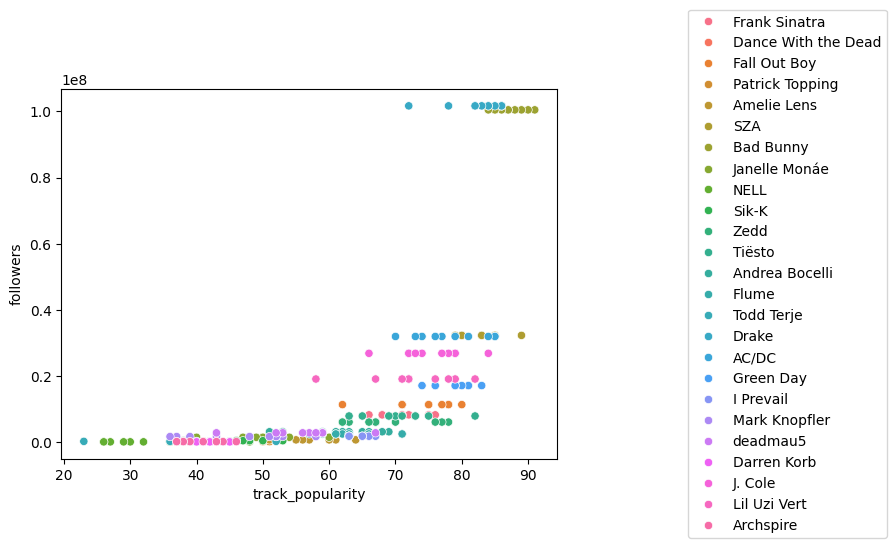

In [101]:
import matplotlib.pyplot as plt
import seaborn as sns

plot = sns.scatterplot(data = top_track_info,
           x = 'track_popularity',
           y = 'followers',
           hue = 'artist_name')

plot.legend(loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=1)
plt.show()

Well, that's not ideal.  We have so many artists that we can't really distinguish the different colors. Let's sample our data to just say 6 levels and plot those.  

To sample I'm randomly selecting six artists by name using `artist_info['artist_name'].sample(6)`.  I'm then filtering the `top_track_info` dataframe to include only values that are in that sample of names using `isin()`.

If you run the plot repeatedly it'll generate a new sample each time.  Give it a go to see how different artists relate to one another!


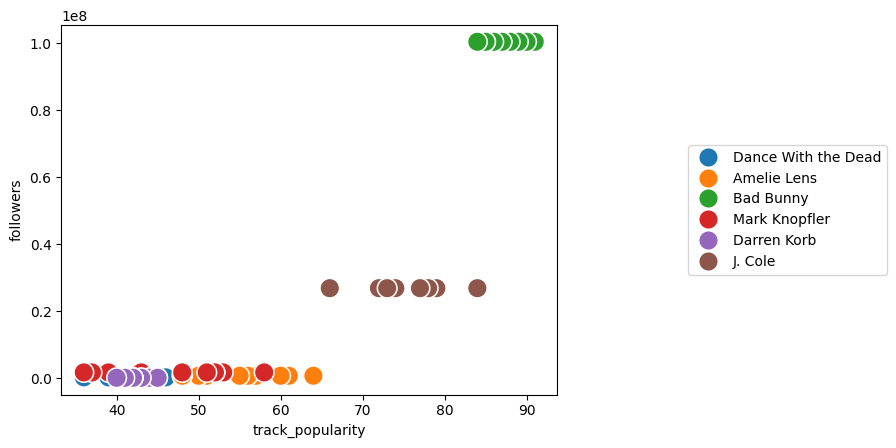

In [102]:
plot = sns.scatterplot(data = top_track_info[top_track_info['artist_name'].isin(artist_info['name'].sample(6))],
           x = 'track_popularity',
           y = 'followers',
           hue = 'artist_name',
           s = 200)

plot.legend(loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=1)
plt.show()

## Rolling it up!

We learned how to do data aggregations. It would be a good idea to do the same here as you might be more interested in the average track_popularty of an artist vs. number of followers.  We can use a `.groupby().agg()` process like last time to group by artist name and then aggregate track info like popularity or duration.

One thing to note.  `groupby()` will automatically set whatever grouping level you use as the index.  This would be fine and you could graph with that. But, I'd rather just keep the artist_name column as an actual column and not as an index.  This  means inside `groupby()` you just add an additional argument `groupby(['artist_name'], as_index = False)`


In [103]:
art_track_agg = top_track_info.groupby(['artist_name'], as_index = False).agg({'track_popularity': ['mean'],
                                                                        'track_duration_ms': ['mean']})
art_track_agg

,artist_name,track_popularity,track_duration_ms
,,mean,mean
0,AC/DC,78.4,260599.6
1,Amelie Lens,55.0,247778.6
2,Andrea Bocelli,61.7,252982.7
3,Archspire,40.6,236542.1
4,Bad Bunny,87.2,230374.0
5,Dance With the Dead,40.6,253100.5
6,Darren Korb,42.6,270573.1
7,Drake,82.545455,222815.818182
8,Fall Out Boy,73.8,205273.4


Cool!  Let's take a minute to rename those columns. We'll also join back on some of the general info about the artists

In [104]:
# Rename like last time
art_track_agg.columns = ['artist_name', 'mean_popularity', 'mean_duration']

Now we can ask some general question such as what artist has the most track duration on average.

In [105]:
# Most duration?
art_track_agg[art_track_agg['mean_duration'] == art_track_agg['mean_duration'].max()]

,artist_name,mean_popularity,mean_duration
22,Todd Terje,39.3,372020.5


In [106]:
# Most popularity?
art_track_agg[art_track_agg['mean_popularity'] == art_track_agg['mean_popularity'].max()]

,artist_name,mean_popularity,mean_duration
4,Bad Bunny,87.2,230374.0


In [107]:
art_track_agg

,artist_name,mean_popularity,mean_duration
0,AC/DC,78.4,260599.6
1,Amelie Lens,55.0,247778.6
2,Andrea Bocelli,61.7,252982.7
3,Archspire,40.6,236542.1
4,Bad Bunny,87.2,230374.0
5,Dance With the Dead,40.6,253100.5
6,Darren Korb,42.6,270573.1
7,Drake,82.545455,222815.818182
8,Fall Out Boy,73.8,205273.4
9,Flume,63.8,242548.8


**Question** [15 points]: Now as practice join the artist info back into art_track_agg and plot the mean populrity vs number of followers (Sample 10 artist instead of 6)


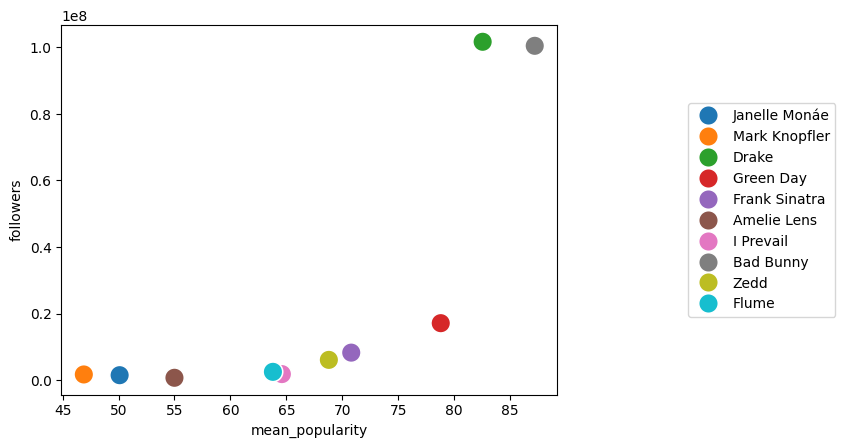

In [108]:
popularity_vs_followers = art_track_agg.merge(artist_info, left_on = 'artist_name', right_on= 'name', how = 'left')
popularity_vs_followers
plot = sns.scatterplot(data = popularity_vs_followers.sample(10),
           x = 'mean_popularity',
           y = 'followers',
           hue = 'artist_name',
           s = 200)

plot.legend(loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=1)
plt.show()